Set up blackjack problem

In [1]:
import random
from collections import namedtuple
Card = namedtuple('Card', ['rank', 'value'])

class BlackjackDeck:
    """Simplified deck for generating card draws."""
    def __init__(self):
        ranks = [str(n) for n in range(2, 11)] + list('JQKA')
        values = list(range(2, 11)) + [10]*3 + [11]
        self._cards = [Card(r,v) for r,v in zip(ranks, values)]

    def draw(self):
        return random.choice(self._cards)


class Dealer:
    def __init__(self, deck: BlackjackDeck):
        self.shown = deck.draw()
        self.hand = [self.shown, deck.draw()]

    @property
    def has_usable_ace(self):
        return 'A' in [h.rank for h in self.hand]

    @property
    def total(self):
        total_ = sum([h.value for h in self.hand])
        if total_ > 21 and self.has_usable_ace:
            total_ -= 10
        return total_
    
    def draw(self, deck: BlackjackDeck):
        self.hand.append(deck.draw())

    @property
    def bust(self):
        return self.total > 21

    def __repr__(self):
        msg = "Dealer("
        msg += ', '.join([h.rank for h in self.hand])
        msg += ')'
        return msg
    
    def policy(self):
        """Static policy for the dealer."""
        if self.total < 17:
            return 'hit'
        return 'stick'
    
    @property
    def has_natural(self):
        if len(self.hand) == 2:
            ranks = [h.rank for h in self.hand]
            vals = [h.value for h in self.hand]
            if 'A' in ranks and 10 in vals:
                return True
        return False

In [2]:
class Player:
    def __init__(self, deck: BlackjackDeck):
        self.hand = [deck.draw(), deck.draw()]

    @property
    def has_usable_ace(self):
        return 'A' in [h.rank for h in self.hand]

    @property
    def total(self):
        total_ = sum([h.value for h in self.hand])
        if total_ > 21 and self.has_usable_ace:
            total_ -= 10
        return total_
    
    def draw(self, deck: BlackjackDeck):
        self.hand.append(deck.draw())

    @property
    def bust(self):
        return self.total > 21

    def __repr__(self):
        msg = "Player("
        msg += ', '.join([h.rank for h in self.hand])
        msg += ')'
        return msg
    
    def policy(self):
        """Player's policy."""
        if self.total <= 19:
            return 'hit'
        return 'stick'
    
    @property
    def has_natural(self):
        if len(self.hand) == 2:
            ranks = [h.rank for h in self.hand]
            vals = [h.value for h in self.hand]
            if 'A' in ranks and 10 in vals:
                return True
        return False

Replicate figure from book

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from collections import defaultdict
def constant_factory():
    return {'r': [], 'n': 0}
State = namedtuple('State', ['player_total', 'dealer_shown_value', 'player_has_usable_ace'])


def run_experiment(n_games: int):
    deck = BlackjackDeck()
    V_S = defaultdict(constant_factory)

    # play a lot of games
    for _ in range(n_games):
        # play a game
        dealer = Dealer(deck)
        player = Player(deck)


        if player.has_natural:
            # game ends right away in either a draw or a win
            s = State(player.total, dealer.shown.value, player.has_usable_ace)
            if dealer.has_natural:
                # draw
                reward = 0.0
            else: # player wins
                reward = 1.0
        else:
            # if player's hand is less than 12, he can always hit safely, so there is no decision
            while player.total < 12:
                player.draw(deck)
            s = State(player.total, dealer.shown.value, player.has_usable_ace) # record state now as "start"

            # decision time:
            while player.policy() == 'hit':
                player.draw(deck)
            if player.bust:
                reward = -1.0
            else:
                # dealer's turn
                while dealer.policy() == 'hit':
                    dealer.draw(deck)
                if dealer.bust:
                    reward = 1.0
                else:
                    # compare player and dealer's hands
                    if player.total > dealer.total:
                        reward = 1.0
                    elif player.total < dealer.total:
                        reward = -1.0
                    else: # draw
                        reward = 0.0


        V_S[s]['r'].append(reward)
        V_S[s]['n'] += 1
    return V_S


def v_s_to_arr(v_s):
    # convert results into an array
    V_s_arr = np.zeros((10, 10, 2))
    for s, res in v_s.items():
        pt, ds, hua = s
        pt_idx = pt - 12
        ds_idx = 0 if ds == 11 else ds - 1
        hua_idx = int(hua)
        r_avg = np.mean(res['r'])
        V_s_arr[pt_idx, ds_idx, hua_idx] = r_avg
    return V_s_arr


def plot_v(v, ax0, ax1):
    X, Y = np.meshgrid(range(0, 10, 1), range(0, 10, 1))

    # Usable ace
    ax0.plot_surface(X=X, Y=Y, Z=v[:,:,1])
    ax0.set(title='Usable Ace', zticks=[-1,1], ylabel='Player sum', xlabel='Dealer showing')
    ax0.set(yticks=range(0,10,1), yticklabels=[str(r) for r in range(12, 22, 1)])
    ax0.set(xticks=range(0,10,1), xticklabels=['A'] + [str(r) for r in range(1,10,1)])
    ax0.get_proj = lambda: np.dot(Axes3D.get_proj(ax0), np.diag([1, 1, 0.25, 1]))
    
    # No usable Ace
    ax1.plot_surface(X=X, Y=Y, Z=v[:,:,0])
    ax1.set(title='No usable Ace', zticks=[-1,1], ylabel='Player sum', xlabel='Dealer showing')
    ax1.set(yticks=range(0,10,1), yticklabels=[str(r) for r in range(12, 22, 1)])
    ax1.set(xticks=range(0,10,1), xticklabels=['A'] + [str(r) for r in range(1,10,1)])
    ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1, 1, 0.25, 1]))

    # plt.show()

# fig, ax = plt.subplots(figsize=(10,10), subplot_kw={"projection": "3d"}, ncols=2, nrows=2)
# plot_v(V_s_arr, ax[0,0], ax[1,0])

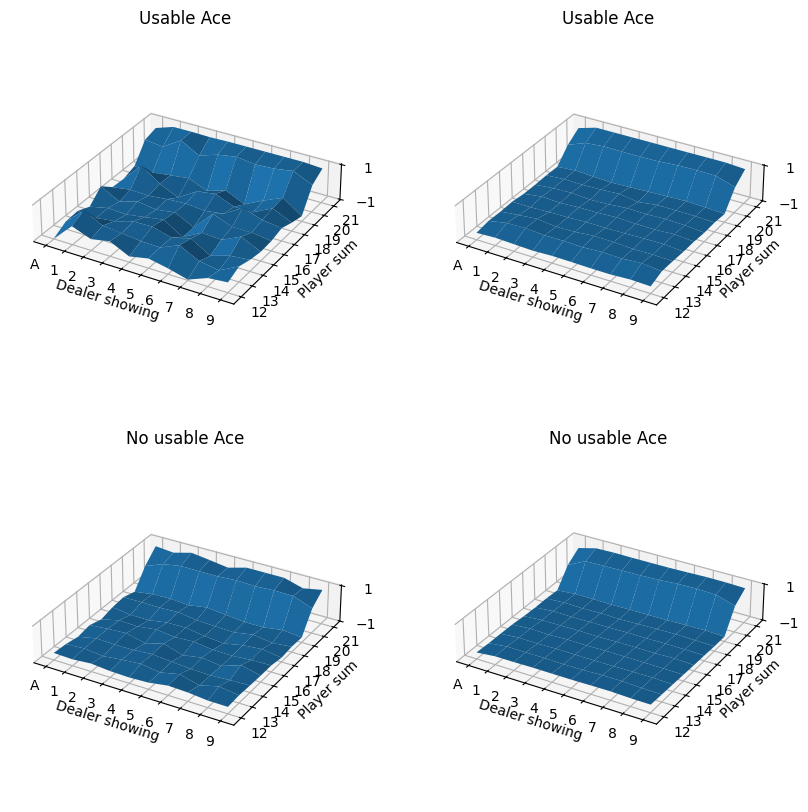

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={"projection": "3d"}, ncols=2, nrows=2)

# 10,000 games
v_s = run_experiment(10_000)
v = v_s_to_arr(v_s)
plot_v(v, ax[0,0], ax[1,0])
        
# 500,000 games
v_s = run_experiment(500_000)
v = v_s_to_arr(v_s)
plot_v(v, ax[0,1], ax[1,1])
plt.show()

# Monte Carlo Control

Generalized Policy Iteration (GPI):
- Maintain an approximate policy and an approximate value function.
- **(Policy Iteration)** Repeatedly alter the value function to more closely approximate the value function for the current policy;
- **(Policy Improvement)** Repeatedly improve the policy in accordance with the current value function.


In the above blackjack example, we had a fixed policy and performed Monte Carlo approximation of the state-value function $v_{\pi}$. When we work with policies, specifically with Policy Improvement, it is easy to act greedily when we have access to the action-value function $q_{\pi}$, via $$ \pi\left(s\right) = \argmax_a q_{\pi}\left(s,a\right) $$

Thus we want to work with $q_{\pi}$ instead of $v_{\pi}$.

In [ ]:
# number of states
len(range(12, 22)) * len(range(1, 11)) * 2

# enumerate all states
map_state_to_idx = { v: k for k, v in enumerate([(a, b, c) for a in range(12, 22) for b in range(1, 11) for c in range(2)]) }

In [ ]:
# need a policy class to allow updating a policy and selecting actions
# given a state s, I want to select an action via argmax
from enum import Enum

class Action(Enum):
    HIT = 0
    STAY = 1

class Q_sa():
    map_state_to_idx = { v: k for k, v in enumerate([(a, b, c) for a in range(12, 22) for b in range(1, 11) for c in range(2)]) }
    def __init__(self):
        self.Q_sa = 0.5 * np.ones((len(map_state_to_idx), 2))

    def __getitem__(self, v):
        s_idx = Q_sa.map_state_to_idx[v[0]]
        return self.Q_sa[s_idx, v[1]]

    def __setitem__(self, key, value):
        s_idx = Q_sa.map_state_to_idx[key[0]]
        self.Q_sa[s_idx, key[1]] = value


class Player():
    def __init__(self, deck: BlackjackDeck):
        self.hand = [deck.draw(), deck.draw()]
        self.Q_sa = Q_sa()
        self.N_sa = np.zeros_like(self.Q_sa.Q_sa)

    def policy(self, state: State):
        """Act in accordance with the current policy."""
        return np.argmax(self.Q_sa[state, :])

    def es(self):
        """Exploring start: randomly choose an action to start with."""
        return np.random.choice([0, 1])

    @property
    def has_usable_ace(self):
        return 'A' in [h.rank for h in self.hand]

    @property
    def total(self):
        total_ = sum([h.value for h in self.hand])
        if total_ > 21 and self.has_usable_ace:
            total_ -= 10
        return total_
    
    def draw(self, deck: BlackjackDeck):
        self.hand.append(deck.draw())

    @property
    def bust(self):
        return self.total > 21

    def __repr__(self):
        msg = "Player("
        msg += ', '.join([h.rank for h in self.hand])
        msg += ')'
        return msg
    
    @property
    def has_natural(self):
        if len(self.hand) == 2:
            ranks = [h.rank for h in self.hand]
            vals = [h.value for h in self.hand]
            if 'A' in ranks and 10 in vals:
                return True
        return False

In [ ]:
Player(deck).es()

1

In [ ]:
from copy import copy
deck = BlackjackDeck()


# play a lot of games
# for _ in range(n_games):
    # play a game
dealer = Dealer(deck)
player = Player(deck)


s_init = State(player.total, dealer.shown.value, player.has_usable_ace)
a_init = player.es()


if player.has_natural:
    # game ends right away in either a draw or a win
    s = State(player.total, dealer.shown.value, player.has_usable_ace)
    if dealer.has_natural:
        # draw
        reward = 0.0
    else: # player wins
        reward = 1.0
else:
    # if player's hand is less than 12, he can always hit safely, so there is no decision
    while player.total < 12:
        player.draw(deck)
    
    s = State(player.total, dealer.shown.value, player.has_usable_ace) # record state now as "start"

    # decision time:
    s_init = copy(s)
    a_init = player.es() # exploring starts

    # proceed with game
    if a_ == 0: # hit
        player.draw(deck)
    while player.policy() == 'hit':
        player.draw(deck)
    if player.bust:
        reward = -1.0
    else:
        # dealer's turn
        while dealer.policy() == 'hit':
            dealer.draw(deck)
        if dealer.bust:
            reward = 1.0
        else:
            # compare player and dealer's hands
            if player.total > dealer.total:
                reward = 1.0
            elif player.total < dealer.total:
                reward = -1.0
            else: # draw
                reward = 0.0


# V_S[s]['r'].append(reward)
# V_S[s]['n'] += 1

TypeError: Player.policy() missing 1 required positional argument: 'state'

In [ ]:
map_s_to_idx = { v: k for k, v in enumerate([(a, b, c) for a in range(12, 22) for b in range(1, 11) for c in range(2)]) }


pi_s = np.random.choice(a=[0,1], size=200) # arbitrary initial policy
Q_sa = np.ones((200, 2))
returns_sa = defaultdict(list)

deck = BlackjackDeck()
# one episode
# random initial state and action

player = Player(deck)
dealer = Dealer(deck)

s_init = (player.total, dealer.shown.value, player.has_usable_ace)
a_init = np.random.choice([0,1]) # hit, stay

episode = [s_init, a_init]
# take action (play out the episode)
if a_init == 0:
    env.step()



In [ ]:
pi_s[map_s_to_idx[(12,1,0)]]

1

In [ ]:
class Env:
    deck = BlackjackDeck()
    def __init__(self):
        self.reset()
        self.episode = []

    def env_step(self, player, action) -> tuple[float, float, bool]: # total, reward, terminated
        if action == 0: # hit
            player.draw(Env.deck)
            if player.bust:
                return (player.total, -1.0, True) # game is over
            else:
                return (player.total, 0.0, False) # game continues

        elif action == 1: # stay
            # dealer takes turn
            # dealer's turn
            while self.dealer.policy() == 'hit':
                self.dealer.draw(deck)
            if self.dealer.bust:
                reward = 1.0
            else:
                # compare player and dealer's hands
                if player.total > self.dealer.total:
                    reward = 1.0
                elif player.total < self.dealer.total:
                    reward = -1.0
                else: # draw
                    reward = 0.0
            return (player.total, reward, True) # game is over


In [ ]:
env = Env()
player = Player(env.deck)

state_init = (player.total, env.dealer.shown.value, player.has_usable_ace)
a_init = player.es()
episode = [state_init, a_init]

# take first step
_, R_t, terminated = env.env_step(player, a_init)
episode.append(R_t)

while not terminated:
    # play according to policy
    S_t = (player.total, env.dealer.shown.value, player.has_usable_ace)
    _, R_t, terminated = env.env_step(player, player.policy(S_t))

# process the results



In [ ]:
gamma = 1.0
G = 0
n_steps = int(len(episode) / 3)
seen = []
sa_ = list()
r_ = list()
for n_step in range(n_steps):
    sa_.append(tuple(episode[3*n_step:3*n_step+2]))
    r_.append(episode[3*n_step+2])

In [ ]:

gamma = 1.0


pi_s = np.random.choice(a=[0,1], size=200) # arbitrary initial policy
Q_sa = np.ones((200, 2))
returns_sa = defaultdict(list)

G = 0
for n_step in range(n_steps):
    t = (n_steps-1) - n_step
    G = gamma * G + r_[t]
    if sa_[t] not in sa_[:t]:
        returns_sa[sa_[t]].append(G)
        s_idx = map_state_to_idx[sa_[t][0]]
        Q_sa[s_idx, sa_[t][1]] = np.mean(returns_sa[sa_[t]])
        pi_s[s_idx] = np.argmax(Q_sa[s_idx, :])

NameError: name 'np' is not defined

In [ ]:
pi_s

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0])

In [ ]:
G

3.0